## Imports

In [21]:
import os
import os.path
import sys
from IPython.display import clear_output
from time import sleep

import numpy as np
import matplotlib.pyplot as plt
from random import randrange

import torch
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch import nn, optim
from torch.utils.data.sampler import Sampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Create Model

In [22]:
from model.mnist_model import model

# Load weigths from the model trained on upstream task
model_file = './mnist.pth'
state_dict = torch.load(model_file)
model.load_state_dict(state_dict)

# Decide whether to freeze or finetune the model
for param in model.parameters():
    param.requires_grad = False

model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=70, gamma=0.1)

Sequential(
  (0): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Flatten()
  (7): Dropout(p=0.2, inplace=False)
  (8): Linear(in_features=6480, out_features=200, bias=True)
  (9): ReLU()
  (10): Dropout(p=0.2, inplace=False)
  (11): Linear(in_features=200, out_features=50, bias=True)
  (12): ReLU()
  (13): Linear(in_features=50, out_features=10, bias=True)
  (14): ReLU()
  (15): Linear(in_features=10, out_features=2, bias=True)
)


## Load Moving MNIST

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 3, 84, 84])
tensor(9)
tensor(6)


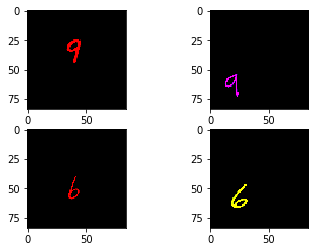

In [26]:
root_directory = '../data/moving_mnist/imgs_train'

from data_util.npair_dataset import FramePairsDataset
from data_util.npair_sampler import VideoFrameSampler
import data_util.simclr_transforms as custom_transform

batch_size = 100
frames_per_epoch = 100
transform = transforms.Compose([
    #custom_transform.get_color_distortion(.1),
    custom_transform.RandomGaussianBluring(5, 1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = FramePairsDataset(root_directory, '.npy', distance=15, transform=transform)

sampler = VideoFrameSampler(len(dataset), frames_per_epoch, 100)

data_loader = torch.utils.data.DataLoader(dataset, batch_size, sampler=sampler)

def test_data_loader(data_loader):
    anchors, positives, labels = iter(data_loader).next()
    print(anchors.shape)
    anchors = anchors.permute(0,2,3,1)
    positives = positives.permute(0,2,3,1)
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
    print(labels[0])
    ax1.imshow(anchors[0])
    ax2.imshow(positives[0])
    print(labels[1])
    ax3.imshow(anchors[1])
    ax4.imshow(positives[1])
    
test_data_loader(data_loader)

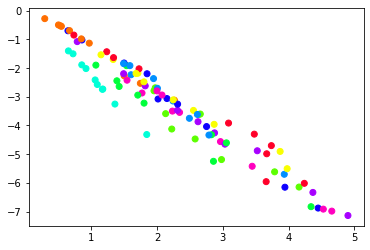

In [27]:
anchors, positives, labels = iter(data_loader).next()
anchors = anchors.to(device)
representation = model(anchors)
X = representation[:,0]
Y = representation[:,1]

plt.scatter(X.cpu(), Y.cpu(), c=labels, cmap= 'gist_rainbow')


## Train the Network

In [ ]:
def train(epoch):
    model.train()
    running_loss = 0
    lr = optimizer.param_groups[0]['lr']
    for images, labels  in train_loader:
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print("Epoch: %3d | Running Loss: %f | LR : %.9f" 
          % (epoch, running_loss, lr))
    return running_loss


def validation():
    model.eval()
    scheduler.step()
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).to(device).sum()
    return correct.item()

In [ ]:
epochs = 20
#max_accuracy = 0
train_losses = []
for epoch in range(epochs):
    train_losses.append(train(epoch))
    if epoch%5 == 0:
        accuracy = validation()
        print("Correct Samples = %d || Accuracy = %.2f" %(accuracy, accuracy*100./len(val_set)))

plt.plot(train_losses)